# Rapport pour le projet Géométrie Algorithmique & Morphologie mathématique

---

## 1 Problématique et but du projet

L’ophtalmoscopie à balayage laser (dite SLO, pour scanning laser ophthalmoscopy) est une modalité
d’imagerie de la rétine permettant de réaliser un fond d’œil à grande résolution et avec un large champ,
et donc d’observer sur une seule image la majeure partie de la surface de la rétine à une résolution entre
10 et 100 µm.\
Outre les maladies de la rétine elle-même, l’observation du fond d’œil permet de diagnostiquer plusieurs
pathologies générales en observant la circulation artérielle et veineuse dans la rétine. C’est le cas en
particulier de l’hypertension artérielle et de l’insuffisance rénale. Le diagnostic repose en général sur
une analyse quantitative de l’ensemble du réseau vasculaire de l’image de rétine, et nécessite donc une
segmentation précise de ce réseau.\
Le but de ce projet est de proposer une méthode automatique de segmentation du réseau vasculaire
dans des images de rétine SLO. La figure 1 montre deux exemples d’images SLO, ainsi que les images de
vérité terrain (Ground Truth), correspondant aux annotations manuelles d’un expert.

## 2 Données et outils informatiques
Les données - images et annotations - sont extraites de la base de données IOSTAR de l’IDIAP pour
l’évaluation d’algorithmes de segmentation de réseau vasculaire rétinien :
https://www.idiap.ch/software/bob/docs/bob/bob.db.iostar/stable/
On ne vous demande pas de télécharger toute la base, mais d’utiliser la sélection fournie dans l’archive
suivante :
https://perso.ensta-paris.fr/~manzaner/Cours/MI206/images_tp2.zip

In [7]:
from slo.evaluate import evaluate_process
from slo.process import apply_denoise_gaussian_canny, apply_sato_hysteresis, apply_background_removal_meijering, apply_background_removal_sato, apply_background_removal_black_tophat
from slo.dataloader import dataload
import numpy as np
import matplotlib.pyplot as plt

Une fois n'est pas coutume, commençons par la fin avec la comparaison des différentes méthodes explorées pour ce projet. Après avoir vu les résultats, nous verrons le détails de ces méthodes, leurs ambitions et leurs limites.

In [2]:
evaluate_process(process=apply_denoise_gaussian_canny)

Evaluate process : apply_denoise_gaussian_canny
Image:star01_OSC.jpg | Accuracy=0.26581 | Recall=0.28923
Image:star21_OSC.jpg | Accuracy=0.2082 | Recall=0.19345
Image:star32_ODC.jpg | Accuracy=0.08059 | Recall=0.09684
Image:star28_ODN.jpg | Accuracy=0.20029 | Recall=0.19634
Image:star37_ODN.jpg | Accuracy=0.14483 | Recall=0.17426
Image:star08_OSN.jpg | Accuracy=0.25272 | Recall=0.23863
Image:star02_OSC.jpg | Accuracy=0.18711 | Recall=0.26091
Image:star03_OSN.jpg | Accuracy=0.25511 | Recall=0.24579
Image:star48_OSN.jpg | Accuracy=0.27885 | Recall=0.31517
Image:star26_ODC.jpg | Accuracy=0.13116 | Recall=0.14221
Mean over metrics : [0.20046599 0.21528235]



In [3]:
evaluate_process(process=apply_sato_hysteresis)

Evaluate process : apply_sato_hysteresis
Image:star01_OSC.jpg | Accuracy=0.73612 | Recall=0.73426
Image:star21_OSC.jpg | Accuracy=0.72633 | Recall=0.60394
Image:star32_ODC.jpg | Accuracy=0.77289 | Recall=0.74521
Image:star28_ODN.jpg | Accuracy=0.72972 | Recall=0.65494
Image:star37_ODN.jpg | Accuracy=0.77138 | Recall=0.71495
Image:star08_OSN.jpg | Accuracy=0.87927 | Recall=0.63987
Image:star02_OSC.jpg | Accuracy=0.64106 | Recall=0.85388
Image:star03_OSN.jpg | Accuracy=0.81847 | Recall=0.64116
Image:star48_OSN.jpg | Accuracy=0.77512 | Recall=0.7403
Image:star26_ODC.jpg | Accuracy=0.75147 | Recall=0.62098
Mean over metrics : [0.76018346 0.69494965]



In [4]:
evaluate_process(process=apply_background_removal_meijering)
evaluate_process(process=apply_background_removal_sato)
evaluate_process(process=apply_background_removal_black_tophat)

Evaluate process : apply_background_removal_meijering
Image:star01_OSC.jpg | Accuracy=0.83254 | Recall=0.77254
Image:star21_OSC.jpg | Accuracy=0.67174 | Recall=0.6275
Image:star32_ODC.jpg | Accuracy=0.6139 | Recall=0.67296
Image:star28_ODN.jpg | Accuracy=0.73003 | Recall=0.68952
Image:star37_ODN.jpg | Accuracy=0.68771 | Recall=0.81863
Image:star08_OSN.jpg | Accuracy=0.74555 | Recall=0.7529
Image:star02_OSC.jpg | Accuracy=0.63196 | Recall=0.74834
Image:star03_OSN.jpg | Accuracy=0.89971 | Recall=0.69273
Image:star48_OSN.jpg | Accuracy=0.66865 | Recall=0.8141
Image:star26_ODC.jpg | Accuracy=0.68491 | Recall=0.66735
Mean over metrics : [0.71667121 0.72565556]

Evaluate process : apply_background_removal_sato
Image:star01_OSC.jpg | Accuracy=0.79854 | Recall=0.73113
Image:star21_OSC.jpg | Accuracy=0.62042 | Recall=0.60623
Image:star32_ODC.jpg | Accuracy=0.61813 | Recall=0.69232
Image:star28_ODN.jpg | Accuracy=0.70184 | Recall=0.68668
Image:star37_ODN.jpg | Accuracy=0.64332 | Recall=0.78113
I

J'ai eu globalement 3 approches dans ce projet, la première est liée à `apply_denoise_gaussian_canny`.
D'abord on débruite, afin de rendre les vaisseaux plus distinguables et lisser le reste, ici avec un filtrage non-local means (NLM), puis on floute légèrement pour éviter des détails inutiles, et on applique un canny filter capable de détecter les contours des vaisseaux. Cette première approche permet de trouver une partie des vaisseaux mais de façon creuse. Plutôt que de poursuivre dans cette direction, j'ai préféré en tenter d'autres.

La seconde approche est liée à `apply_sato_hysteresis`. En effet le filtre sato est particulièrement adapté à la recherche de structure tubulaires de tailles variables dans une image. Ce n'est pas le seul filtre, meijering, frangi sont d'autres filtres du même acabit. Sato permet de faire ressortir les plus gros vaisseaux en blanc et les plus petits de plus en plus grisés. Il reste ensuite à utiliser un seuillage par hystérésis pour capter uniquement les plus importants et leurs embranchements. A cela s'ajoute une tentative d'isoler le rond où se croise de nombreux vaisseaux et qui n'est pas labelisé dans nos données. Malheureusement la méthode fondée sur `skimage.graph.central_pixel` pour avoir les pixels ayant la plus grande mesure de centralité ne s'est pas montrée efficace.

La dernière approche explorée dans ce projet est de partir sur la tâche "inverse". Sur les images, on ne voit globalement que des vaisseaux sur un fond avec de grandes zones homogènes qui se mélangent. L'objectif de cette dernière approche est donc de retirer le fond et de faire ressortir les vaisseaux.\
Pour retirer le fond, on a retirer l'image passée par un filtre médian à l'image originale puis augmenté le contraste.
Suite à quoi, il reste les vaisseaux et de nombreux petits groupes de pixels sombres uniforméments répartis.\ Différentes techniques pour s'en débarasser ont donnée les différentes méthodes testées ci-dessus : `apply_background_removal_meijering`, `apply_background_removal_sato`, `apply_background_removal_black_tophat`


`apply_background_removal_meijering` était facile à équilibrer en terme de precision/recall avec le meijering de fin. Et ses performances sont "correctes". Je poursuis donc en montrant les résultats obtenus pour cette méthode. 

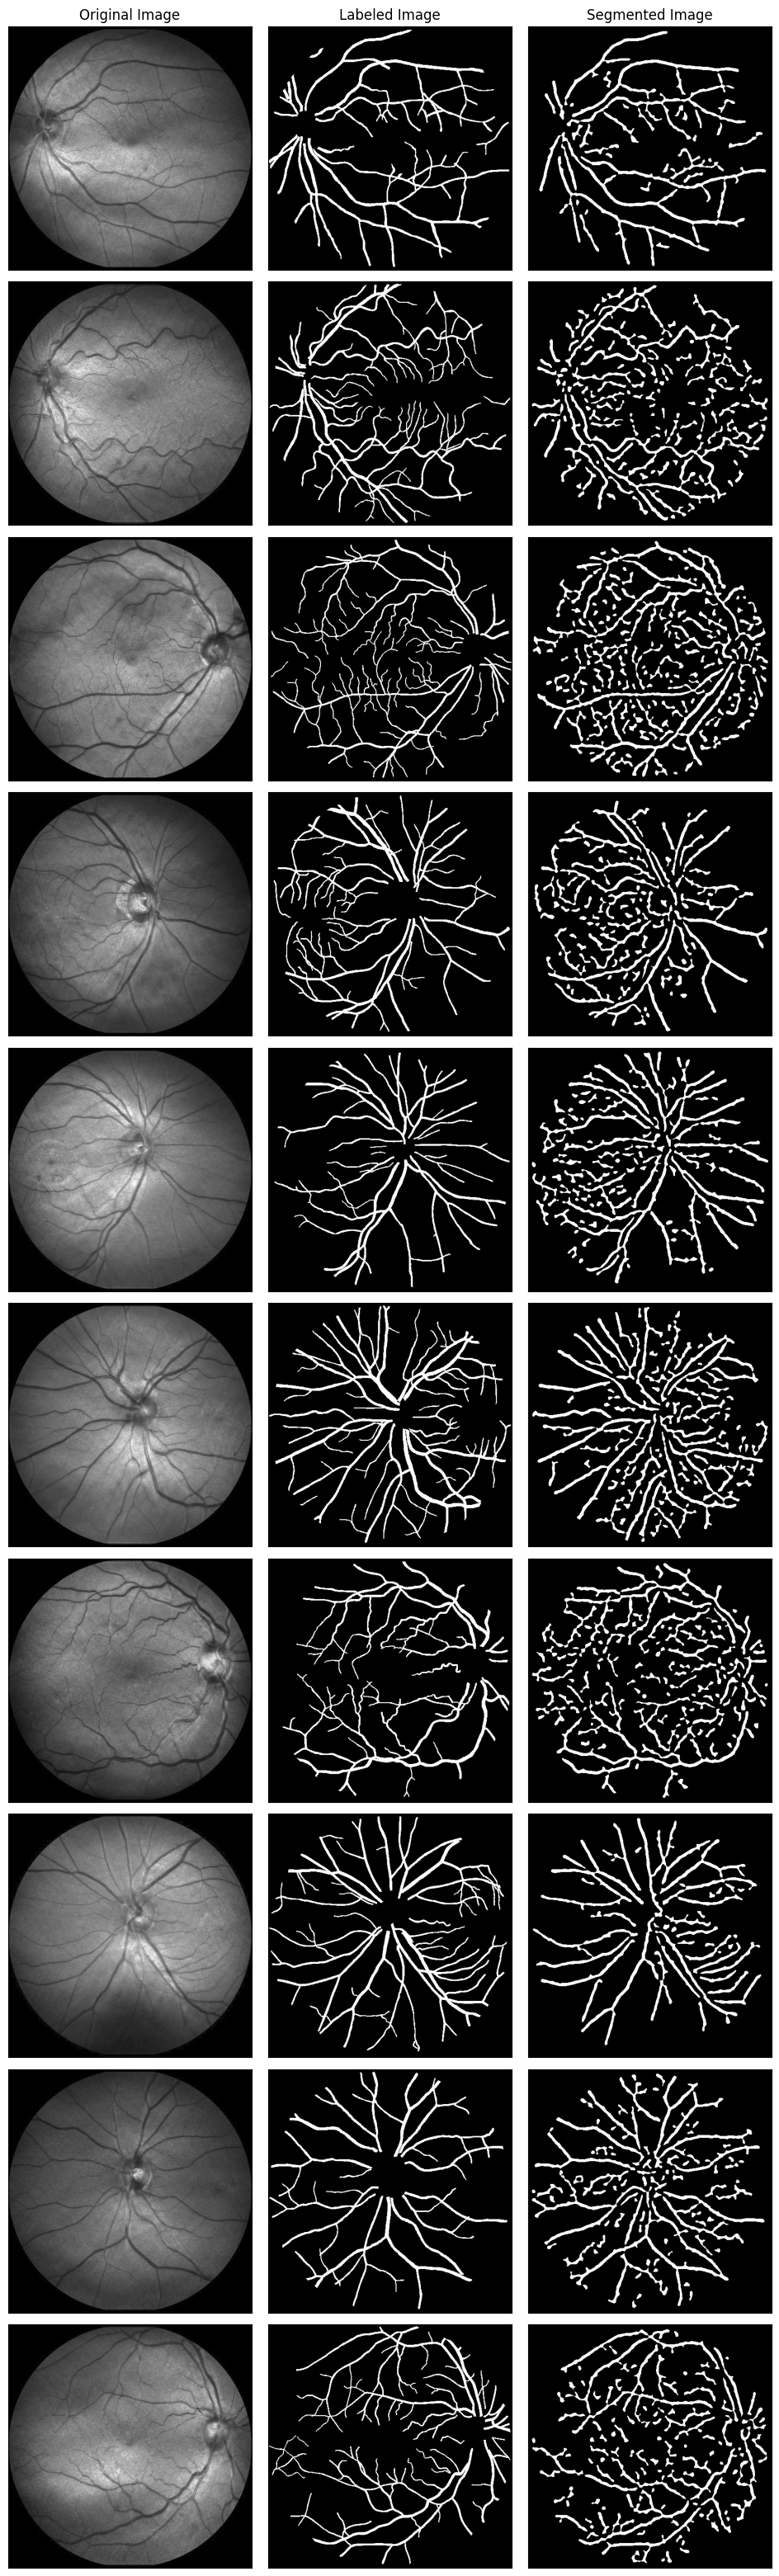

In [8]:
data = list(enumerate(dataload()))
n = len(data)

# Create a figure and set the size
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i, d in data:
    img = np.asarray(d['image']).astype(np.uint8)
    img_GT =  np.asarray(d['label']).astype(np.bool_)
    img_seg = apply_background_removal_meijering(img)
    
    # Display the original image, labeled image, and segmented image in their respective columns
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 1].imshow(img_GT, cmap='gray')
    axes[i, 2].imshow(img_seg, cmap='gray')

    # Set the titles for the first row
    if i == 0:
        axes[i, 0].set_title('Original Image')
        axes[i, 1].set_title('Labeled Image')
        axes[i, 2].set_title('Segmented Image')

    # Remove the axis ticks
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 2].set_xticks([])
    axes[i, 2].set_yticks([])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Show the plot
plt.show()

On constate qu'il manque des vaisseaux parmi les plus difficiles à détecter sur l'image de départ, et que du bruit subsiste autour des vaisseaux détectés. On pourrait imaginer ajouter une méthode qui se focalise sur les vaisseaux non détectés et qui le fasse sans baisser la precision. Il faudrait de plus reconstruire les vaisseaux que l'on voit entrecoupés. Pour le bruit, il existe certainement des méthodes pour retirer les embranchements en trop (courts et orthogonaux aux vaisseaux corrects).

---

## 3 Questions et pistes de réflexion

### 1. La notion de multi-échelles est essentielle pour ce type d’algorithme, les vaisseaux étant d’épaisseur variable.

La notion de multi-échelles est essentielle pour ce type d'algorithme, car les vaisseaux présentent des épaisseurs variées. En utilisant des techniques multi-échelle, avec des éléments structurants de différentes tailles et des filtres appliqués à différentes échelles on peut extraire des caractéristiques et des structures pertinentes pour les vaisseaux de diverses largeurs.\
Dans ce projet on utilise des fonctions que l'on pourrait qualifier de multi-échelle comme `skimage.filters.threshold_local`, `skimage.filters.apply_hysteresis_threshold` et `skimage.filters.sato`. 

### 2. Le réseau vasculaire étant en général connecté, l’utilisation d’opérateurs connexes semble pertinente.

Le réseau vasculaire est généralement connecté, donc l'utilisation d'opérateurs connexes semble pertinente. Les opérateurs de morphologie mathématique et les techniques de reconstruction sont bien adaptées pour traiter les structures connexes, car ils prennent en compte les relations spatiales entre les pixels. Cela permet d'améliorer la segmentation des vaisseaux en préservant mieux la continuité des vaisseaux sanguins.
Moins d'opérateurs connexes ont été utilisés dans ce projet, mais on peut y trouver `skimage.morphology.remove_small_objects` et des constructions sur des opérateurs morphologiques comme l'érosion et la dilatation.

### 3. Expliquez la fonction d’évaluation fournie dans le script Python. Pourquoi utilise-t-on deux métriques (Précision et Rappel) ? Quel rôle joue la squelettisation dans cette fonction d’évaluation ?

La Précision mesure la proportion de vrais positifs parmi tous les pixels détectés comme appartenant aux vaisseaux. Elle indique la capacité de l'algorithme à ne détecter que les vaisseaux réels et à éviter les faux positifs. Autrement dit à ne pas avoir de pixels blancs en trop sur notre segmentation. Le Rappel mesure la proportion de vrais positifs parmi tous les pixels réels des vaisseaux. Il indique la capacité de l'algorithme à "rappeler" tous les vaisseaux réels.\ 
L'utilisation de ces deux métriques permet de fournir une évaluation plus complète de la performance de l'algorithme, car un algorithme peut avoir une Précision élevée mais un faible Rappel, ou vice versa. En examinant les deux métriques, on peut avoir une meilleure compréhension de la manière dont l'algorithme détecte les vrais vaisseaux et évite les erreurs.\
La squelettisation réduit les vaisseaux segmentés à une ligne centrale, simplifiant ainsi la comparaison entre les vaisseaux détectés et les vaisseaux réels. Cela permet de quantifier plus précisément la qualité de la détection des vaisseaux en éliminant les variations d'épaisseur et en se concentrant uniquement sur les structures centrales des vaisseaux.